In [166]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from Transformer import *

# Import the utils from the Time2Vec Transformer
import sys
sys.path.append("../Time2Vec")
from utils import *

import warnings

warnings.filterwarnings('ignore')

monthly = pd.read_csv('../../../Dataset/Boulder_Monthly.csv')
monthly.drop(columns={'Unnamed: 0'}, inplace=True)
monthly.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Energy__kWh_   55 non-null     float64
 1   Month          55 non-null     object 
 2   Minimum T      55 non-null     int64  
 3   Maximum T      55 non-null     int64  
 4   Snow           55 non-null     float64
 5   Precipitation  55 non-null     float64
dtypes: float64(3), int64(2), object(1)
memory usage: 2.7+ KB


    Scale the Dataset with MinMaxScaler / One-Hot Encode and Extract the Entire Scaled Dataset

In [167]:
# Define the columns we need to scale and we need to use for One-Hot Encoding
columns_to_scale = ['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation']
categorical_columns = ['Month']

# MinMax scaling for numerical columns and One-hot encoding for categorical columns
scaler = MinMaxScaler()
monthly_scaled = monthly.copy()
monthly_scaled[columns_to_scale] = scaler.fit_transform(monthly[columns_to_scale])

# One-hot encoding for categorical columns
onehot_encoder = OneHotEncoder(sparse=False)
categorical_encoded = onehot_encoder.fit_transform(monthly[categorical_columns])

# Get the feature names from the encoder
encoded_columns = []
for col, values in zip(categorical_columns, onehot_encoder.categories_):
    encoded_columns.extend([f'{col}_{value}' for value in values])

# Create DataFrame with encoded columns
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=encoded_columns)

# Concatenate the new encoded columns to the original DataFrame
monthly_scaled = pd.concat([monthly_scaled, categorical_encoded_df], axis=1)

# Drop the original categorical columns
monthly_scaled = monthly_scaled.drop(categorical_columns, axis=1)
monthly_scaled.columns

Index(['Energy__kWh_', 'Minimum T', 'Maximum T', 'Snow', 'Precipitation',
       'Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September'],
      dtype='object')

    Divided the dataset into training, testing, and validation datasets according to 0.70, 0.20, and 0.10, respectively.

In [168]:
train_monthly_scaled, val_monthly_scaled, test_monthly_scaled = split_dataset(monthly_scaled, train_ratio=0.7, val_ratio=0.2)

Training split ratio:   0.691
Validation split ratio: 0.2
Testing split ratio:    0.109

Shapes of the datasets:
(38, 17) (11, 17) (6, 17)


    Create sequences for the Transformer model

In [169]:
sequence_length = 5
num_features = len(monthly_scaled.columns)

# Create the training, validation, and test data sequences
train_data_inputs, train_data_targets = create_sequences(train_monthly_scaled, sequence_length)
val_data_inputs, val_data_targets = create_sequences(val_monthly_scaled, sequence_length)
test_data_inputs, test_data_targets = create_sequences(test_monthly_scaled, sequence_length)

Dataset split into sequences:
Sequences shape: (33, 5, 17)
Targets shape: (33,)

Dataset split into sequences:
Sequences shape: (6, 5, 17)
Targets shape: (6,)

Dataset split into sequences:
Sequences shape: (1, 5, 17)
Targets shape: (1,)



    Create the Transformer Models

In [170]:
# Define the hyperparameters of the manual model
num_heads = 1
d_ff = 64
num_layers = 3
dropout_rate = 0.1
encoder_mask = None
decoder_mask = tf.linalg.band_part(tf.ones((sequence_length, sequence_length)), -1, 0)  # Create a lower triangular mask
decoder_mask = 1 - decoder_mask  # Invert the mask


if __name__ == "__main__":
   manual_model = main(sequence_length, num_features, num_heads, d_ff, num_layers, dropout_rate, encoder_mask, decoder_mask)


Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 5, 17)]      0           []                               
                                                                                                  
 multi_head_attention_182 (Mult  (None, None, 17)    1224        ['input_21[0][0]',               
 iHeadAttention)                                                  'input_21[0][0]',               
                                                                  'input_21[0][0]']               
                                                                                                  
 dropout_386 (Dropout)          (None, None, 17)     0           ['multi_head_attention_182[0][0]'
                                                                 ]                         

In [171]:
# Create the transformer model
input_shape = (sequence_length, num_features)
keras_model = keras_transformer_model(input_shape, num_heads, d_ff, num_layers, dropout_rate)

keras_model.summary()

Model: "model_21"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 5, 17)]      0           []                               
                                                                                                  
 multi_head_attention_189 (Mult  (None, 5, 17)       372         ['input_22[0][0]',               
 iHeadAttention)                                                  'input_22[0][0]']               
                                                                                                  
 dropout_402 (Dropout)          (None, 5, 17)        0           ['multi_head_attention_189[0][0]'
                                                                 ]                                
                                                                                           

    Compile the Models

In [172]:
# Define the learning rate for Adam optimizer
learning_rate = 0.1

# Compile the manual model
manual_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

# Compile the keras model
keras_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse',  metrics=['mae', 'mse', root_mean_squared_error])

    Train the Models

In [173]:
# Define the parameters for training
epochs = 200
batch_size = 32

# Convert the data to float32
train_data_inputs = train_data_inputs.astype('float32')
train_data_targets = train_data_targets.astype('float32')

val_data_inputs = val_data_inputs.astype('float32')
val_data_targets = val_data_targets.astype('float32')

train_data_inputs.shape, train_data_targets.shape, val_data_inputs.shape, val_data_targets.shape

((33, 5, 17), (33,), (6, 5, 17), (6,))

In [174]:
# Train the manual model
history_manual = manual_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/200


2/2 [==============================] - 7s 1s/step - loss: 0.2055 - mae: 0.3759 - mse: 0.2055 - root_mean_squared_error: 0.2862 - val_loss: 0.0704 - val_mae: 0.2298 - val_mse: 0.0704 - val_root_mean_squared_error: 0.2654
Epoch 2/200
2/2 [==============================] - 0s 47ms/step - loss: 0.1085 - mae: 0.2389 - mse: 0.1085 - root_mean_squared_error: 0.1872 - val_loss: 0.0310 - val_mae: 0.1344 - val_mse: 0.0310 - val_root_mean_squared_error: 0.1760
Epoch 3/200
2/2 [==============================] - 0s 46ms/step - loss: 0.0734 - mae: 0.2278 - mse: 0.0734 - root_mean_squared_error: 0.2263 - val_loss: 0.0176 - val_mae: 0.1166 - val_mse: 0.0176 - val_root_mean_squared_error: 0.1326
Epoch 4/200
2/2 [==============================] - 0s 48ms/step - loss: 0.0654 - mae: 0.2027 - mse: 0.0654 - root_mean_squared_error: 0.3536 - val_loss: 0.0176 - val_mae: 0.1168 - val_mse: 0.0176 - val_root_mean_squared_error: 0.1327
Epoch 5/200
2/2 [==============================] - 0s 46ms/step - loss: 0.0652

In [175]:
# Train the keras model
history_keras = keras_model.fit(train_data_inputs, train_data_targets,
          validation_data=(val_data_inputs, val_data_targets),
          epochs=epochs, batch_size=batch_size)

Epoch 1/200
2/2 [==============================] - 12s 2s/step - loss: 0.2007 - mae: 0.3708 - mse: 0.2007 - root_mean_squared_error: 0.3227 - val_loss: 0.0209 - val_mae: 0.1188 - val_mse: 0.0209 - val_root_mean_squared_error: 0.1447
Epoch 2/200
2/2 [==============================] - 0s 56ms/step - loss: 0.1078 - mae: 0.2518 - mse: 0.1078 - root_mean_squared_error: 0.3120 - val_loss: 0.0177 - val_mae: 0.1174 - val_mse: 0.0177 - val_root_mean_squared_error: 0.1329
Epoch 3/200
2/2 [==============================] - 0s 56ms/step - loss: 0.0760 - mae: 0.2122 - mse: 0.0760 - root_mean_squared_error: 0.1838 - val_loss: 0.0403 - val_mae: 0.1757 - val_mse: 0.0403 - val_root_mean_squared_error: 0.2008
Epoch 4/200
2/2 [==============================] - 0s 234ms/step - loss: 0.0936 - mae: 0.2352 - mse: 0.0936 - root_mean_squared_error: 0.5095 - val_loss: 0.0194 - val_mae: 0.1174 - val_mse: 0.0194 - val_root_mean_squared_error: 0.1392
Epoch 5/200
2/2 [==============================] - 0s 68ms/step 

    Evaluate the Models

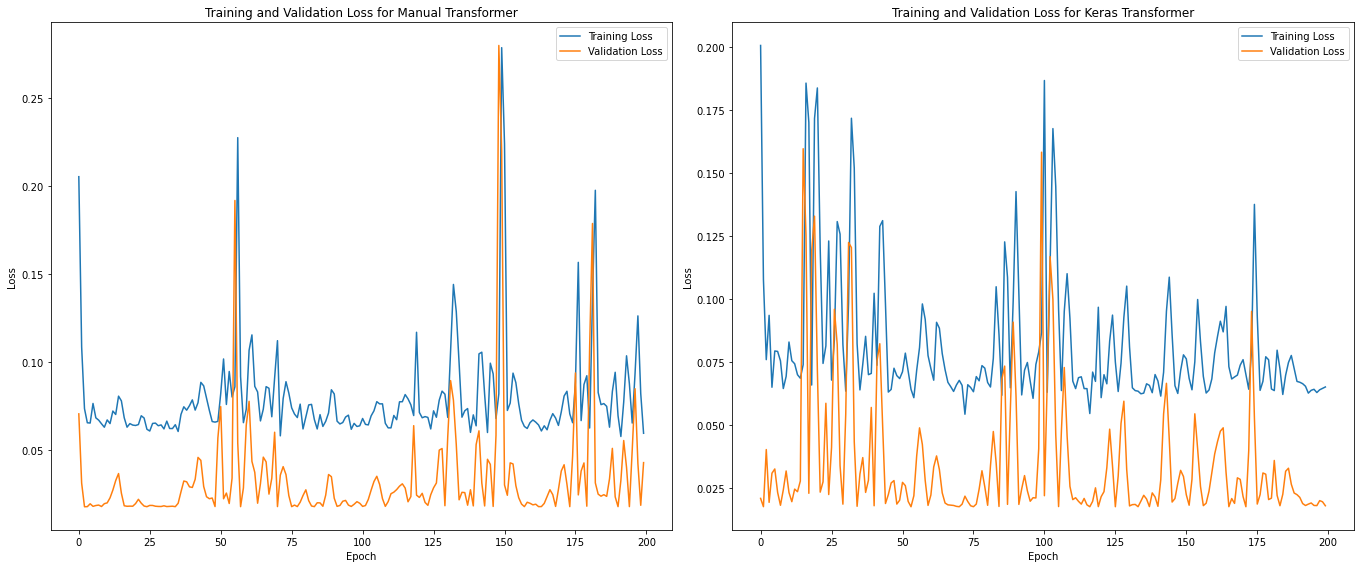

In [176]:
def plot_loss(history, model_name, ax):
    ax.plot(history.history['loss'], label='Training Loss')
    ax.plot(history.history['val_loss'], label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training and Validation Loss for ' + model_name)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(19, 8))

histories = [history_manual, history_keras]
model_names = ['Manual Transformer', 'Keras Transformer']

for history, model_name, ax in zip(histories, model_names, axes):
    plot_loss(history, model_name, ax)

plt.tight_layout()
plt.show()

In [177]:
# Evaluate on validation set
val_metrics_manual = manual_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)
val_metrics_keras = keras_model.evaluate(val_data_inputs, val_data_targets, return_dict=True)

# Evaluate on test set
test_metrics_manual = manual_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)
test_metrics_keras = keras_model.evaluate(test_data_inputs, test_data_targets, return_dict=True)

# Extract individual metrics
val_loss_manual, val_mae_manual, val_mse_manual, val_rmse_manual = val_metrics_manual['loss'], val_metrics_manual['mae'], val_metrics_manual['mse'], val_metrics_manual['root_mean_squared_error']
test_loss_manual, test_mae_manual, test_mse_manual, test_rmse_manual = test_metrics_manual['loss'], test_metrics_manual['mae'], test_metrics_manual['mse'], test_metrics_manual['root_mean_squared_error']

val_loss_keras, val_mae_keras, val_mse_keras, val_rmse_keras = val_metrics_keras['loss'], val_metrics_keras['mae'], val_metrics_keras['mse'], val_metrics_keras['root_mean_squared_error']
test_loss_keras, test_mae_keras, test_mse_keras, test_rmse_keras = test_metrics_keras['loss'], test_metrics_keras['mae'], test_metrics_keras['mse'], test_metrics_keras['root_mean_squared_error']

print('\n\nManual Transformer:\n-------------------')
print(f'Validation Loss: {val_loss_manual}, Validation MSE: {val_mse_manual}, Validation MAE: {val_mae_manual}, Validation RMSE: {val_rmse_manual}')
print(f'Test Loss: {test_loss_manual}, Test MSE: {test_mse_manual}, Test MAE: {test_mae_manual}, Test RMSE: {test_rmse_manual}')

print('\nKeras Transformer:\n------------------')
print(f'Validation Loss: {val_loss_keras}, Validation MSE: {val_mse_keras}, Validation MAE: {val_mae_keras}, Validation RMSE: {val_rmse_keras}')
print(f'Test Loss: {test_loss_keras}, Test MSE: {test_mse_keras}, Test MAE: {test_mae_keras}, Test RMSE: {test_rmse_keras}')

1/1 [==============================] - 0s 37ms/step - loss: 0.0406 - mae: 0.2014 - mse: 0.0406 - root_mean_squared_error: 0.2014


Manual Transformer:
-------------------
Validation Loss: 0.04268496111035347, Validation MSE: 0.04268496111035347, Validation MAE: 0.16355927288532257, Validation RMSE: 0.20660339295864105
Test Loss: 0.003962179180234671, Test MSE: 0.003962179180234671, Test MAE: 0.06294584274291992, Test RMSE: 0.06294585019350052

Keras Transformer:
------------------
Validation Loss: 0.018018024042248726, Validation MSE: 0.018018024042248726, Validation MAE: 0.11739814281463623, Validation RMSE: 0.13423123955726624
Test Loss: 0.040564004331827164, Test MSE: 0.040564004331827164, Test MAE: 0.20140507817268372, Test RMSE: 0.20140507817268372


In [178]:
# Assuming manual_model.predict returns the predictions
val_predictions_manual = manual_model.predict(val_data_inputs)
test_predictions_manual = manual_model.predict(test_data_inputs)

# Assuming keras_model.predict returns the predictions
val_predictions_keras = keras_model.predict(val_data_inputs)
test_predictions_keras  = keras_model.predict(test_data_inputs)

# Calculate MAE and RMSE for validation set
val_mae_manual = np.mean(np.abs(val_data_targets - val_predictions_manual))
val_rmse_manual = np.sqrt(np.mean(np.square(val_data_targets - val_predictions_manual)))

val_mae_keras  = np.mean(np.abs(val_data_targets - val_predictions_keras ))
val_rmse_keras  = np.sqrt(np.mean(np.square(val_data_targets - val_predictions_keras )))

# Calculate MAE and RMSE for test set
test_mae_manual = np.mean(np.abs(test_data_targets - test_predictions_manual))
test_rmse_manual = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_manual)))

test_mae_keras  = np.mean(np.abs(test_data_targets - test_predictions_keras ))
test_rmse_keras  = np.sqrt(np.mean(np.square(test_data_targets - test_predictions_keras )))


print('\n\nManual Transformer:\n-------------------')
print(f'Validation MAE: {val_mae_manual}')
print(f'Validation RMSE: {val_rmse_manual}')
print(f'\nTest MAE: {test_mae_manual}')
print(f'Test RMSE: {test_rmse_manual}')
print('\n==============================')
print('\nKeras Transformer:\n------------------')
print(f'Validation MAE: {val_mae_keras }')
print(f'Validation RMSE: {val_rmse_keras }')
print(f'\nTest MAE: {test_mae_keras }')
print(f'Test RMSE: {test_rmse_keras }')

1/1 [==============================] - 0s 43ms/step


Manual Transformer:
-------------------
Validation MAE: 0.16356465220451355
Validation RMSE: 0.20660491287708282

Test MAE: 0.06294581319613579
Test RMSE: 0.06294581319613579


Keras Transformer:
------------------
Validation MAE: 0.11739814281463623
Validation RMSE: 0.13423123955726624

Test MAE: 0.20140504862589959
Test RMSE: 0.20140504862589959


In [179]:
def calculate_mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def evaluate_predictions_model(model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler):
    # Predictions on training data
    y_pred_train = model.predict(train_data_inputs)
    inversed_y_pred_train = scaler.inverse_transform(np.concatenate([y_pred_train, np.zeros((y_pred_train.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_train = inversed_y_pred_train[:, 0]

    # Inverse the target train data
    train_targets_scaled_data = train_data_targets.reshape(-1,1)
    train_targets_data = scaler.inverse_transform(np.concatenate([train_targets_scaled_data, np.zeros((train_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    train_targets_data = train_targets_data[:, 0]

    # Metrics on training data
    train_rmse = calculate_rmse(train_targets_data, inversed_y_pred_train)
    train_mae = calculate_mae(train_targets_data, inversed_y_pred_train)

    # Predictions on validation data
    y_pred_val = model.predict(val_data_inputs)
    inversed_y_pred_val = scaler.inverse_transform(np.concatenate([y_pred_val, np.zeros((y_pred_val.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_val = inversed_y_pred_val[:, 0]
    
    # Inverse the target validation data
    val_targets_scaled_data = val_data_targets.reshape(-1,1)
    val_targets_data = scaler.inverse_transform(np.concatenate([val_targets_scaled_data, np.zeros((val_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    val_targets_data = val_targets_data[:, 0]

    # Metrics on validation data
    val_rmse = calculate_rmse(val_targets_data, inversed_y_pred_val)
    val_mae = calculate_mae(val_targets_data, inversed_y_pred_val)

    # Predictions on test data
    y_pred_test = model.predict(test_data_inputs)
    inversed_y_pred_test = scaler.inverse_transform(np.concatenate([y_pred_test, np.zeros((y_pred_test.shape[0], scaler.n_features_in_-1))], axis=1))
    inversed_y_pred_test = inversed_y_pred_test[:, 0]

    test_targets_scaled_data = test_data_targets.reshape(-1,1)
    test_targets_data = scaler.inverse_transform(np.concatenate([test_targets_scaled_data, np.zeros((test_targets_scaled_data.shape[0], scaler.n_features_in_-1))], axis=1))
    test_targets_data = test_targets_data[:, 0]

    # Metrics on test data
    test_rmse = calculate_rmse(test_targets_data, inversed_y_pred_test)
    test_mae = calculate_mae(test_targets_data, inversed_y_pred_test)
    
    # Print the results
    print(f"\n\nEvaluation metrics for {model_name} model:\n-------------------")
    print('Train Dataset:')
    print(f"RMSE: {train_rmse}")
    print(f"MAE: {train_mae}\n-------------------")

    print('Validation Dataset:')
    print(f"RMSE: {val_rmse}")
    print(f"Validation MAE: {val_mae}\n-------------------")
    
    print('Test Dataset:')
    print(f"Test RMSE: {test_rmse}")
    print(f"Test MAE: {test_mae}\n\n")

In [180]:
evaluate_predictions_model(manual_model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler)
evaluate_predictions_model(keras_model, model_name, train_data_inputs, train_data_targets, val_data_inputs, val_data_targets, test_data_inputs, test_data_targets, scaler)

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - 0s 40ms/step


Evaluation metrics for Keras Transformer model:
-------------------
Train Dataset:
RMSE: 4258.390722710659
MAE: 3603.3371581592546
-------------------
Validation Dataset:
RMSE: 2990.391277288047
Validation MAE: 2367.367874213442
-------------------
Test Dataset:
Test RMSE: 911.0819175703527
Test MAE: 911.0819175703527


1/1 [==============================] - 0s 33ms/step


Evaluation metrics for Keras Transformer model:
-------------------
Train Dataset:
RMSE: 3629.308201815872
MAE: 2956.2762951423915
-------------------
Validation Dataset:
RMSE: 1942.8718196260113
Validation MAE: 1699.2285128811445
-------------------
Test Dataset:
Test RMSE: 2915.1501679495277
Test MAE: 2915.1501679495277


